# Disaggregation of appliances from generated load profiles

## Open questions:
- Does an appliance count as 'on' if it is active at _any_ time within a given window?

In [1]:
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Tensorflow
import tensorflow as tf
from pyts.image import GramianAngularField
from scipy.signal import find_peaks
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Scripts
import utils

pd.set_option("display.precision", 10)
pd.set_option("display.max_columns", 500)

%matplotlib inline

c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Constants
DATA_PATH = "data/6_months"
MODEL_PATH = "2D-CNN/" + DATA_PATH.split("/")[-1]

In [3]:
df = pd.read_csv(f"{DATA_PATH}/data_reduced.csv", index_col=0)
df

c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Target
0,0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
15638395,15638395,2021-06-30 23:59:55,0.0,0.0,0.0,0.0,0.0,0.0
15638396,15638396,2021-06-30 23:59:56,0.0,0.0,0.0,0.0,0.0,0.0
15638397,15638397,2021-06-30 23:59:57,0.0,0.0,0.0,0.0,0.0,0.0
15638398,15638398,2021-06-30 23:59:58,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
appliances = ["Stove", "Coffee_machine", "Microwave", "Dishwasher", "Washing_machine"]

# Convert time series data to windowed data frame

In [4]:
window_size = 180
step = 1

In [5]:
windowed_data_path = f"{DATA_PATH}/windowed_{window_size}_step_{step}_noisy.csv"

In [7]:
df_timeseries = utils.write_or_load_windows(
    windowed_data_path, df, window_size, step, appliances
)
df_timeseries

Loading existing window file data/6_months/windowed_180_step_1_noisy.csv


c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.0001567047,0.0001387678,0.0001570701,0.0001525167,0.0001582124,0.0001363594,0.0001502016,0.0001524143,0.0001433487,0.0001599655,0.0001496477,0.0001550041,0.0001477059,0.0001462401,0.0001441854,0.0001484884,0.0001509225,0.0001599853,0.0001473093,0.0001455594,0.0001617919,0.0001459716,0.0001523487,0.0001484821,0.0001380473,0.0001502253,0.0001517571,0.0001573660,0.0001586774,0.0001377296,0.0001396824,0.0001418023,0.0001519152,0.0001604267,0.0001485330,0.0001453387,0.0001598725,0.0001496837,0.0001537660,0.0001357789,0.0001529094,0.0001514478,0.0001554339,0.0001562052,0.0001525792,0.0001392569,0.0001384204,0.0001432295,0.0001434882,0.0001396081,0.0001375167,0.0001530931,0.0001387494,0.0001622797,0.0001546164,0.0001497845,0.0001528894,0.0001494679,0.0001522063,0.0001457176,0.0001460168,0.0001414556,0.0001460309,0.0001465982,0.0001447985,0.0001639070,0.0001328957,0.0001519047,0.0001398323,0.0001590326,0.0001514081,0.0001529710,0.0001351505,0.0001478810,0.0001428016,0.0001473621,0.0001448259,0.0001506248,0.0001442177,0.0001488766,0.0001504755,0.0001541620,0.0001495985,0.0001552328,0.0001437602,0.0001449125,0.0001461283,0.0001600534,0.0001423270,0.0001381453,0.0001671616,0.0001470570,0.0001480087,0.0001534178,0.0001492486,0.0001351401,0.0001442496,0.0001489050,0.0001325454,0.0001488421,0.0001400687,0.0001435467,0.0001567003,0.0001596137,0.0001479796,0.0001445594,0.0001491363,0.0001454473,0.0001548101,0.0001414508,0.0001343948,0.0001456909,0.0001399058,0.0001557608,0.0001504713,0.0001472402,0.0001394553,0.0001523024,0.0001518415,0.0001361274,0.0001485977,0.0001379649,0.0001441583,0.0001482136,0.0001355378,0.0001546165,0.0001394558,0.0001587925,0.0001598724,0.0001473018,0.0001499426,0.0001482724,0.0001462232,0.0001441178,0.0001472607,0.0001405876,0.0001454499,0.0001411768,0.0001459480,0.0001391442,0.0001424453,0.0001386773,0.0001334870,0.0001477652,0.0001462036,0.0001455096,0.0001565148,0.0001584786,0.0001462157,0.0001542855,0.0001566466,0.0001514815,0.0001464976,0.0001465478,0.0001352764,0.0001516162,0.0001488211,0.0001377643,0.0001548558,0.

## Undersampling

In [8]:
counts = []
for appliance in appliances:
    count = utils.count_non_zero_rows(df_timeseries, appliance)
    counts.append(count)
    print(appliance, count)

max_class_freq = max(counts)
print(f"Highest class count --->  {max_class_freq}")

Stove 178021
Coffee_machine 35674
Microwave 49561
Dishwasher 292795
Washing_machine 109558
Highest class count --->  292795


In [9]:
df_sampled_negative = df_timeseries.loc[
    (df_timeseries["Stove"] == 0)
    & (df_timeseries["Coffee_machine"] == 0)
    & (df_timeseries["Microwave"] == 0)
    & (df_timeseries["Dishwasher"] == 0)
    & (df_timeseries["Washing_machine"] == 0)
].sample(max_class_freq)
df_sampled_negative

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
2016603,0.0000246436,0.0000261237,0.0000254214,0.0000262265,0.0000240936,0.0000266086,0.0000253783,0.0000237997,0.0000244956,0.0000243374,0.0000233706,0.0000251619,0.0000240177,0.0000242735,0.0000257247,0.0000223403,0.0000252153,0.0000256055,0.0000217177,0.0000251332,0.0000215698,0.0000271532,0.0000231698,0.0000235924,0.0000220397,0.0000252307,0.0000242482,0.0000245017,0.0000217296,0.0000236807,0.0000231027,0.0000246654,0.0000259545,0.0000239354,0.0000254171,0.0000226216,0.0000260089,0.0000230667,0.0000246575,0.0000243115,0.0000244361,0.0000231779,0.0000251468,0.0000228441,0.0000233991,0.0000256407,0.0000231591,0.0000236705,0.0000229483,0.0000258360,0.0000219523,0.0000239885,0.0000263731,0.0000250983,0.0000247717,0.0000257157,0.0000246452,0.0000253782,0.0000251613,0.0000245972,0.0000258150,0.0000240168,0.0000222232,0.0000249284,0.0000253923,0.0000246147,0.0000232082,0.0000247767,0.0000235988,0.0000232296,0.0000260527,0.0000266896,0.0000263352,0.0000250442,0.0000251611,0.0000249186,0.0000259871,0.0000236107,0.0000231531,0.0000246521,0.0000249573,0.0000240422,0.0000269449,0.0000270834,0.0000228912,0.0000231078,0.0000230816,0.0000259694,0.0000249055,0.0000264387,0.0000224849,0.0000253247,0.0000251089,0.0000250853,0.0000242511,0.0000244862,0.0000263726,0.0000248491,0.0000256905,0.0000221217,0.0000251766,0.0000223143,0.0000246889,0.0000264973,0.0000207457,0.0000217485,0.0000260155,0.0000227984,0.0000259322,0.0000260506,0.0000257934,0.0000260308,0.0000246292,0.0000262377,0.0000267214,0.0000235749,0.0000265241,0.0000258124,0.0000249719,0.0000245423,0.0000231969,0.0000258961,0.0000240264,0.0000253326,0.0000257231,0.0000244708,0.0000256686,0.0000244076,0.0000278785,0.0000250084,0.0000240166,0.0000255816,0.0000250798,0.0000228572,0.0000222064,0.0000232186,0.0000264149,0.0000252652,0.0000242557,0.0000215069,0.0000226385,0.0000246568,0.0000256710,0.0000250086,0.0000240768,0.0000268896,0.0000226856,0.0000227712,0.0000238866,0.0000270931,0.0000258392,0.0000243441,0.0000246771,0.0000236485,0.0000240814,0.0000258723,0.0000508562,0.0000459482,0.0000468

In [10]:
drop_indices = df_timeseries.loc[
    (df_timeseries["Stove"] == 0)
    & (df_timeseries["Coffee_machine"] == 0)
    & (df_timeseries["Microwave"] == 0)
    & (df_timeseries["Dishwasher"] == 0)
    & (df_timeseries["Washing_machine"] == 0)
].index
df_timeseries = df_timeseries.drop(drop_indices)
df_timeseries

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
5801,0.0001150814,0.0001028167,0.0000982280,0.0000978033,0.0001049534,0.0001090628,0.0001222314,0.0000908688,0.0001138711,0.0001016264,0.0000913862,0.0001012317,0.0001006560,0.0000999293,0.0001067863,0.0001009807,0.0000987747,0.0001045543,0.0001277292,0.0001207036,0.0001148617,0.0001050584,0.0001081868,0.0001076230,0.0001085562,0.0001050742,0.0001136484,0.0000998194,0.0001045620,0.0001023783,0.0000945825,0.0000982752,0.0001035310,0.0001204556,0.0000964053,0.0001121859,0.0000955048,0.0000894152,0.0001089969,0.0001183245,0.0001017188,0.0001058321,0.0001022378,0.0001040601,0.0001151654,0.0001085038,0.0000975390,0.0001033449,0.0001153765,0.0001198990,0.0001044204,0.0000937835,0.0001042194,0.0000970797,0.0001005553,0.0001013076,0.0001139331,0.0001000349,0.0001076008,0.0001075074,0.0001045950,0.0001107857,0.0001113337,0.0001045678,0.0000912397,0.0001009663,0.0000951903,0.0001028779,0.0001050292,0.0001167737,0.0001105582,0.0000998473,0.0001025445,0.0001040329,0.0000891352,0.0001162969,0.0001089656,0.0001018061,0.0000983806,0.0001138651,0.0001070411,0.0001064470,0.0001036650,0.0001059379,0.0000933205,0.0001061110,0.0001002123,0.0001161186,0.0000997755,0.0001154568,0.0001044540,0.0001131706,0.0001146369,0.0001051062,0.0001005692,0.0001031914,0.0001045182,0.0001106083,0.0001016332,0.0001095336,0.0001009123,0.0001110059,0.0001032681,0.0001063872,0.0001094074,0.0001043231,0.0000893283,0.0001084087,0.0001080175,0.0001046406,0.0001037662,0.0001105248,0.0001101214,0.0001003734,0.0001111418,0.0001012965,0.0001110380,0.0001076332,0.0001062325,0.0001269977,0.0001189380,0.0001113719,0.0001107640,0.0001022852,0.0001023609,0.0001100178,0.0001087612,0.0000941662,0.0001178399,0.0001200536,0.0000974293,0.0001136230,0.0001051876,0.0001167966,0.0001080765,0.0001124502,0.0001070541,0.0001138840,0.0001112675,0.0001071105,0.0001083894,0.0000972269,0.0001045643,0.0001079144,0.0001057618,0.0001125989,0.0001082620,0.0000911013,0.0001131629,0.0001003787,0.0001018255,0.0001119543,0.0001060228,0.0001179146,0.0001033008,0.0001026716,0.0001022579,0.0000965914,0.0001036480

In [11]:
df_timeseries = pd.concat([df_sampled_negative, df_timeseries])
df_timeseries.reset_index(inplace=True)
df_timeseries.drop(columns=["index"], inplace=True)
df_timeseries

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.0000246436,0.0000261237,0.0000254214,0.0000262265,0.0000240936,0.0000266086,0.0000253783,0.0000237997,0.0000244956,0.0000243374,0.0000233706,0.0000251619,0.0000240177,0.0000242735,0.0000257247,0.0000223403,0.0000252153,0.0000256055,0.0000217177,0.0000251332,0.0000215698,0.0000271532,0.0000231698,0.0000235924,0.0000220397,0.0000252307,0.0000242482,0.0000245017,0.0000217296,0.0000236807,0.0000231027,0.0000246654,0.0000259545,0.0000239354,0.0000254171,0.0000226216,0.0000260089,0.0000230667,0.0000246575,0.0000243115,0.0000244361,0.0000231779,0.0000251468,0.0000228441,0.0000233991,0.0000256407,0.0000231591,0.0000236705,0.0000229483,0.0000258360,0.0000219523,0.0000239885,0.0000263731,0.0000250983,0.0000247717,0.0000257157,0.0000246452,0.0000253782,0.0000251613,0.0000245972,0.0000258150,0.0000240168,0.0000222232,0.0000249284,0.0000253923,0.0000246147,0.0000232082,0.0000247767,0.0000235988,0.0000232296,0.0000260527,0.0000266896,0.0000263352,0.0000250442,0.0000251611,0.0000249186,0.0000259871,0.0000236107,0.0000231531,0.0000246521,0.0000249573,0.0000240422,0.0000269449,0.0000270834,0.0000228912,0.0000231078,0.0000230816,0.0000259694,0.0000249055,0.0000264387,0.0000224849,0.0000253247,0.0000251089,0.0000250853,0.0000242511,0.0000244862,0.0000263726,0.0000248491,0.0000256905,0.0000221217,0.0000251766,0.0000223143,0.0000246889,0.0000264973,0.0000207457,0.0000217485,0.0000260155,0.0000227984,0.0000259322,0.0000260506,0.0000257934,0.0000260308,0.0000246292,0.0000262377,0.0000267214,0.0000235749,0.0000265241,0.0000258124,0.0000249719,0.0000245423,0.0000231969,0.0000258961,0.0000240264,0.0000253326,0.0000257231,0.0000244708,0.0000256686,0.0000244076,0.0000278785,0.0000250084,0.0000240166,0.0000255816,0.0000250798,0.0000228572,0.0000222064,0.0000232186,0.0000264149,0.0000252652,0.0000242557,0.0000215069,0.0000226385,0.0000246568,0.0000256710,0.0000250086,0.0000240768,0.0000268896,0.0000226856,0.0000227712,0.0000238866,0.0000270931,0.0000258392,0.0000243441,0.0000246771,0.0000236485,0.0000240814,0.0000258723,0.0000508562,0.0000459482,0.0000468543,0.

In [12]:
samples = [x for i, x in enumerate(df_timeseries.columns) if x not in appliances]
X = df_timeseries.loc[:, samples]
y = df_timeseries.loc[:, appliances]

## Possible time-/frequency-based features
- min
- max
- num peaks
- stddev
- variance
- mean
- median
- sum
- mean change
- rms

inspiration taken from tsfresh

# Gramian Angular Fields

In [13]:
del df_sampled_negative
del drop_indices
del df_timeseries

In [14]:
import gc

gc.collect()

99

# Train-test split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=False
)

In [17]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [18]:
from PIL import Image

In [19]:
list(y_train.iloc[0])

[0, 0, 0, 0, 0]

In [19]:
def create_GAFs(df, label_df, path, GAF_method, count):
    gasf = GramianAngularField(method=GAF_method)
    IMAGE_PATH = f"GAF/{path}"
    selected_rows = []
    i = 0
    for window in df.itertuples():
        #         if i % 1000 == 0:
        #             print(f"Current index: {window[0]}")
        if i > count - 1:
            break
        if 1 not in list(label_df.iloc[window[0]]):
            continue
        selected_rows.append(window[0])
        window_array = np.array([window[1:]])
        gasf_row = gasf.fit_transform(window_array)
        # Plot the time series and its recurrence plot
        width_ratios = (2, 7, 7, 0.4)
        height_ratios = (2, 7)
        width = 10
        height = width * sum(height_ratios) / sum(width_ratios)
        fig = plt.figure(figsize=(width, height))
        # Plot the Gramian angular fields on the bottom right
        ax_gasf = fig.add_subplot()
        plt.axis("off")
        plt.imsave(
            f"{IMAGE_PATH}/window_{window[0]}.png", arr=gasf_row[0], cmap="rainbow"
        )
        plt.close()
        i = i + 1
    return selected_rows
    ################################################

In [20]:
train_rows = create_GAFs(X_train, y_train, "train", "summation", 25000)

In [21]:
val_rows = create_GAFs(X_val, y_val, "val", "summation", 1000)

In [22]:
test_rows = create_GAFs(X_test, y_test, "test", "summation", 4000)

In [23]:
import os

count = 0
dir_path = "GAF/train"
for path in os.scandir(dir_path):
    if path.is_file():
        count += 1
print("file count:", count)

file count: 25000


In [24]:
def rows_to_dataframe(X, y, rows):
    dataframe = pd.DataFrame(
        columns=[
            "X",
            "Stove",
            "Coffee_machine",
            "Microwave",
            "Dishwasher",
            "Washing_machine",
        ],
    )

    for idx, row in enumerate(rows):
        dataframe.at[idx, "X"] = f"window_{row}.png"
        dataframe.at[idx, "Stove"] = y.iloc[idx][0]
        dataframe.at[idx, "Coffee_machine"] = y.iloc[idx][1]
        dataframe.at[idx, "Microwave"] = y.iloc[idx][2]
        dataframe.at[idx, "Dishwasher"] = y.iloc[idx][3]
        dataframe.at[idx, "Washing_machine"] = y.iloc[idx][4]
    for appliance in appliances:
        dataframe = dataframe.astype({appliance: np.float32})
    return dataframe

In [25]:
train_df_mapping = rows_to_dataframe(X_train, y_train, train_rows)
val_df_mapping = rows_to_dataframe(X_val, y_val, val_rows)
test_df_mapping = rows_to_dataframe(X_test, y_test, test_rows)

In [6]:
train_df_mapping = pd.read_csv("image_csvs/train.csv", index_col=0)
val_df_mapping = pd.read_csv("image_csvs/val.csv", index_col=0)
test_df_mapping = pd.read_csv("image_csvs/test.csv", index_col=0)

In [7]:
for appliance in appliances:
    train_df_mapping = train_df_mapping.astype({appliance: np.float32})
    val_df_mapping = val_df_mapping.astype({appliance: np.float32})
    test_df_mapping = test_df_mapping.astype({appliance: np.float32})

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_ds = train_datagen.flow_from_dataframe(
    train_df_mapping,
    directory="GAF/train",
    x_col="X",
    y_col=appliances,
    batch_size=16,
    seed=42,
    target_size=(window_size, window_size),
    class_mode="raw",
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_ds = val_datagen.flow_from_dataframe(
    val_df_mapping,
    directory="GAF/val",
    x_col="X",
    y_col=appliances,
    batch_size=16,
    seed=42,
    target_size=(window_size, window_size),
    class_mode="raw",
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_datagen.flow_from_dataframe(
    test_df_mapping,
    directory="GAF/test",
    x_col="X",
    y_col=appliances,
    batch_size=16,
    seed=42,
    target_size=(window_size, window_size),
    class_mode="raw",
)

Found 8000 validated image filenames.
Found 1000 validated image filenames.
Found 2000 validated image filenames.


# Modeling

In [9]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import AveragePooling1D, Conv1D, MaxPooling1D
from keras.models import Sequential

In [10]:
EPOCHS = 50
BATCH_SIZE = 64

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, verbose=2, restore_best_weights=True
    ),
]

# Architecture insights
- Best model so far is true_DLO_doppelte_filter_60er_kernel_model with batch size 256, window size 180 with f1 scores between 88-96%, accuracy ~87% and LR at 5e-07
- GlobalMaxPooling seems to improve results on strongly imbalanced classes but worsens performance on "main" classes

In [20]:
from keras.layers import *


def create_model():
    kernel_size = (20, 20)
    filter_size = 128
    dropout = 0.3
    input_layer = keras.layers.Input(shape=(window_size, window_size, 3))
    conv1 = keras.layers.Conv2D(
        filters=filter_size,
        kernel_size=kernel_size,
        activation="relu",
    )(input_layer)
    conv1 = keras.layers.MaxPool2D()(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(dropout)(conv1)

    conv2 = keras.layers.Conv2D(
        filters=filter_size, kernel_size=kernel_size, activation="relu"
    )(conv1)
    conv2 = keras.layers.MaxPool2D()(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(dropout)(conv2)

    conv3 = keras.layers.Conv2D(
        filters=filter_size, kernel_size=kernel_size, activation="relu"
    )(conv2)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.MaxPool2D()(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(dropout)(conv3)

    gap = keras.layers.GlobalMaxPooling2D()(conv3)

    output_layer = keras.layers.Dense(len(appliances), activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [21]:
LR = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
f"Setting learning rate to {LR}"

'Setting learning rate to 0.001'

In [22]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [23]:
model = create_model()

In [24]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["AUC", "binary_accuracy"])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 161, 161, 128)     153728    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 80, 80, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 80, 80, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 128)       655372

In [26]:
history = model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/50
500/500 [==============================] - 115s 196ms/step - loss: 0.3831 - auc: 0.6702 - binary_accuracy: 0.8729 - val_loss: 0.5779 - val_auc: 0.5507 - val_binary_accuracy: 0.7004 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 97s 193ms/step - loss: 0.3325 - auc: 0.6987 - binary_accuracy: 0.8860 - val_loss: 0.5327 - val_auc: 0.6261 - val_binary_accuracy: 0.7580 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 94s 188ms/step - loss: 0.3305 - auc: 0.7017 - binary_accuracy: 0.8863 - val_loss: 0.5333 - val_auc: 0.6418 - val_binary_accuracy: 0.7368 - lr: 0.0010
Epoch 4/50
190/500 [==========>...................] - ETA: 57s - loss: 0.3306 - auc: 0.6959 - binary_accuracy: 0.8870

InternalError: Could not synchronize CUDA stream: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

In [25]:
THRESHOLD = 0.5
y_pred = model.predict(test_ds)
y_pred[y_pred >= THRESHOLD] = 1
y_pred[y_pred < THRESHOLD] = 0
y_pred

63/63 [==============================] - 4s 64ms/step


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [26]:
test_loss, test_auc, test_acc = model.evaluate(test_ds)

print("Test AUC", test_auc)
print("Test Acc", test_acc)
print("Test loss", test_loss)

63/63 [==============================] - 3s 40ms/step - loss: 0.5069 - auc: 0.7081 - binary_accuracy: 0.7513
Test AUC 0.7080712914466858
Test Acc 0.7512999773025513
Test loss 0.5069001317024231


In [37]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5774630805038493

In [29]:
MODEL_NAME = "128,128,128 CNN"

In [44]:
model.save(f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}")

INFO:tensorflow:Assets written to: models_concat/6_months/DLO_128,128,128_60er_kernel_GlobalMaxPool,3x128_Dense_model_noisy/LR=8e-06,Epochs=100,BATCH=64\assets


INFO:tensorflow:Assets written to: models_concat/6_months/DLO_128,128,128_60er_kernel_GlobalMaxPool,3x128_Dense_model_noisy/LR=8e-06,Epochs=100,BATCH=64\assets


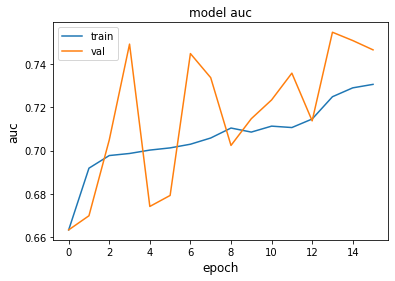

In [31]:
metric = "auc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.savefig(f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}")
plt.show()
plt.close()

In [35]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(test_ds.labels, y_pred)

print(
    classification_report(
        test_ds.labels, y_pred, target_names=appliances, zero_division=False
    )
)

                 precision    recall  f1-score   support

          Stove       0.29      0.00      0.01       558
 Coffee_machine       0.00      0.00      0.00       122
      Microwave       0.10      0.02      0.03       157
     Dishwasher       0.50      0.01      0.03      1085
Washing_machine       0.30      0.02      0.04       496

      micro avg       0.25      0.01      0.02      2418
      macro avg       0.24      0.01      0.02      2418
   weighted avg       0.36      0.01      0.02      2418
    samples avg       0.01      0.01      0.01      2418



Accuracy: 0.7195


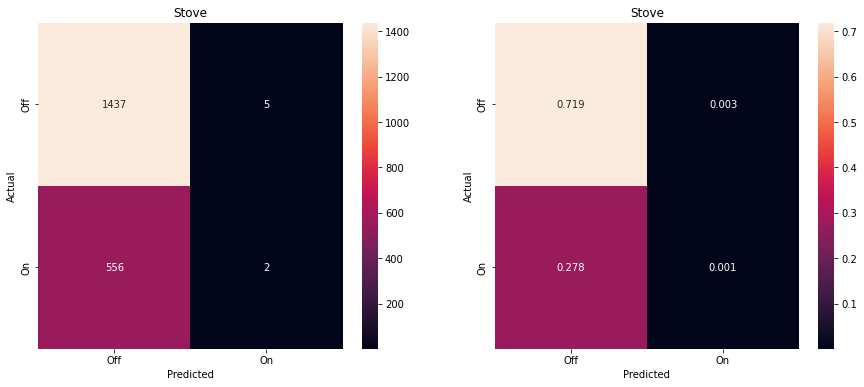

Accuracy: 0.93


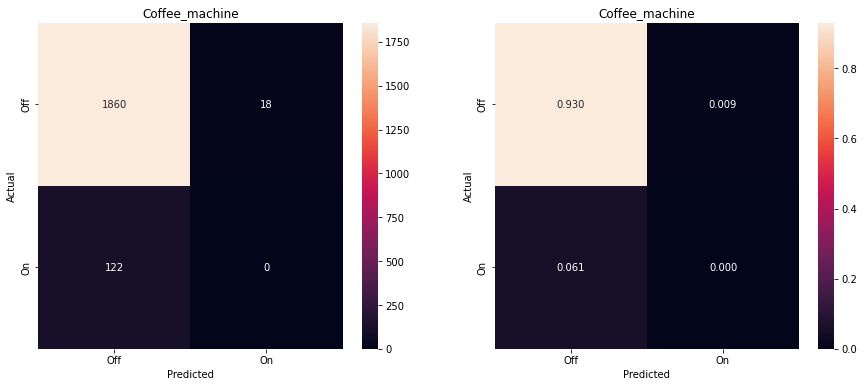

Accuracy: 0.91


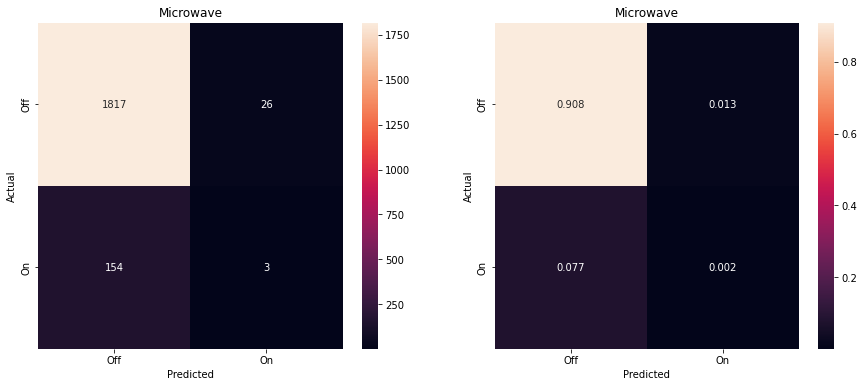

Accuracy: 0.4575


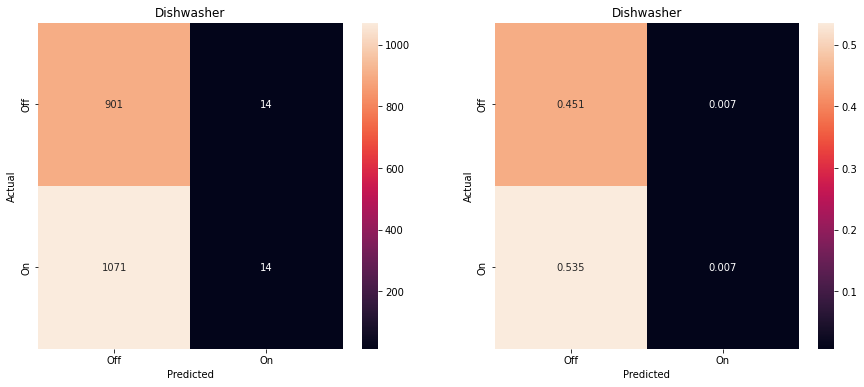

Accuracy: 0.7455


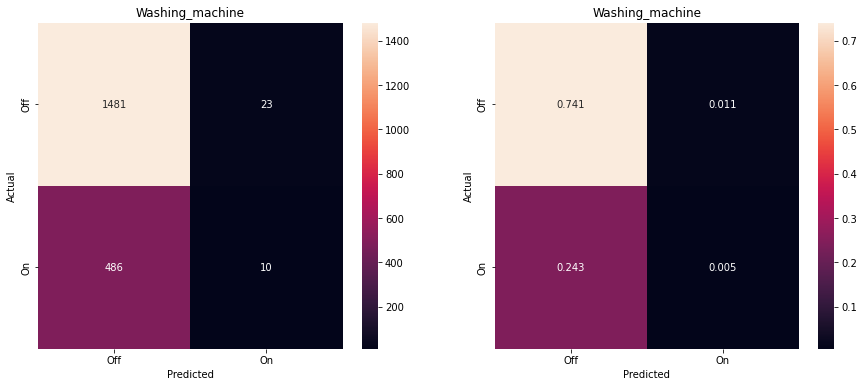

In [36]:
columns = ["Off", "On"]
for idx, item in enumerate(mcm):
    tn, fp, fn, tp = item.ravel()
    print(f"Accuracy: {(tp+tn)/(tn+fp+fn+tp)}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    heat = sns.heatmap(
        item, annot=True, fmt="1", xticklabels=columns, yticklabels=columns, ax=ax1
    )
    norm_item = item.astype("float") / item.sum(axis=None)
    norm_heat = sns.heatmap(
        norm_item,
        annot=True,
        fmt=".3f",
        xticklabels=columns,
        yticklabels=columns,
        ax=ax2,
    )
    for ax in [ax1, ax2]:
        ax.set_title(appliances[idx])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.show()